# PETRONAS Petrol Station Sentiment Analysis using Google Places API
We have a set of latitude and longitude data of PETRONAS Petrol station courtesy of PDB internal database. What we can do with this data is to use the latitude and longitude and get the google review and rating of each station using Google Places. We will then save this data inside a dataframe, and use it to establish a sentiment analysis


In [1]:
#load the library first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('Retail_station.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   StationName            1138 non-null   object 
 1   FuelAccount            1138 non-null   int64  
 2   SegmentName            1135 non-null   object 
 3   SubSegmentName         1137 non-null   object 
 4   CompanyName            1138 non-null   object 
 5   Address1               1138 non-null   object 
 6   Address2               809 non-null    object 
 7   City                   1137 non-null   object 
 8   PostCode               1137 non-null   float64
 9   State                  1137 non-null   object 
 10  RegionName             1137 non-null   object 
 11  RegionGroup            1137 non-null   object 
 12  Country                1138 non-null   object 
 13  Latitude               1138 non-null   float64
 14  Longitude              1138 non-null   object 
 15  Land

In [2]:
#extract all the columns from the dataframe
df.columns

Index(['StationName', 'FuelAccount', 'SegmentName', 'SubSegmentName',
       'CompanyName', 'Address1', 'Address2', 'City', 'PostCode', 'State',
       'RegionName', 'RegionGroup', 'Country', 'Latitude', 'Longitude',
       'LandConcept', 'LandConceptIsActive', 'LandConceptDataSource',
       'StationConcept', 'StationStatus', 'MaxRoadTankerSize',
       'SetelActivationStatus', 'DeliveryOpenTimeFrom', 'DeliveryOpenTimeTo',
       'NoDeliveryIntrvl1From', 'NoDeliveryIntrvl1To', 'NoDeliveryIntrvl2From',
       'NoDeliveryIntrvl2To', 'SoldToNumber', 'SoldToNumberName1',
       'RetailStationIsActive'],
      dtype='object')

In [3]:
new_col = ['StationName','Latitude','Longitude']

df_loc = df[new_col]
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   StationName  1138 non-null   object 
 1   Latitude     1138 non-null   float64
 2   Longitude    1138 non-null   object 
dtypes: float64(1), object(2)
memory usage: 26.8+ KB


In [4]:
import requests
import pandas as pd
import time
import os
from dotenv import load_dotenv

load_dotenv()

# Replace with your own API key
api_key = os.getenv("GOOGLE_API_KEY")

# Function to get place details with a limit on number of reviews
def get_place_reviews(place_id, api_key, max_reviews=5):
    endpoint = "https://maps.googleapis.com/maps/api/place/details/json"
    params = {
        "place_id": place_id,
        "fields": "rating,reviews",
        "key": api_key
    }
    response = requests.get(endpoint, params=params)
    data = response.json()
    
    # Check if reviews exist and return them, limited to max_reviews
    reviews = data.get('result', {}).get('reviews', [])
    return reviews[:max_reviews]  # Limit the number of reviews

# Function to find petrol stations near given coordinates
def find_petrol_stations(lat, lng, api_key):
    endpoint = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    params = {
        "location": f"{lat},{lng}",
        "radius": 500,  # Search within a 500 meter radius
        "type": "gas_station",  # Filter to only return petrol stations
        "key": api_key
    }
    response = requests.get(endpoint, params=params)
    data = response.json()
    
    # Return the list of places with their place IDs
    places = []
    if 'results' in data:
        for place in data['results']:
            places.append({
                'place_id': place['place_id'],
                'name': place['name'],
                'location': f"{lat},{lng}"
            })
    return places

# List to hold all reviews
all_reviews_list = []

# Define the batch size
batch_size = 50

# Loop through the DataFrame in batches
for start in range(0, len(df_loc), batch_size):
    end = start + batch_size
    df_batch = df_loc.iloc[start:end]
    
    # Process each row in the current batch
    for index, row in df_batch.iterrows():
        lat, lng = row['Latitude'], row['Longitude']
        
        # Find petrol stations near the given coordinates
        petrol_stations = find_petrol_stations(lat, lng, api_key)
        
        # Get reviews for each petrol station found
        for station in petrol_stations:
            reviews = get_place_reviews(station['place_id'], api_key, max_reviews=5)
            
            # Add the reviews to the all_reviews_list
            for review in reviews:
                all_reviews_list.append({
                    'station_name': row['StationName'],  # Link to input station
                    'place_name': station['name'],
                    'location': station['location'],
                    'author_name': review['author_name'],
                    'rating': review['rating'],
                    'text': review['text'],
                    'time': review['time']
                })
    
    # Convert current batch of reviews to a DataFrame and append to the main DataFrame
    df_batch_reviews = pd.DataFrame(all_reviews_list)
    
    # Check if the main DataFrame exists
    if 'df_all_reviews' not in globals():
        df_all_reviews = df_batch_reviews
    else:
        df_all_reviews = pd.concat([df_all_reviews, df_batch_reviews], ignore_index=True)
    
    # Clear the all_reviews_list for the next batch
    all_reviews_list = []
    
    # Optional: Save progress after each batch
    df_all_reviews.to_csv('reviews_backup.csv', index=False)
    
    # Print progress
    print(f"Processed rows {start} to {end} out of {len(df_loc)}")

    # Optional: Delay between batches to avoid API rate limits
    time.sleep(2)

# Display the final DataFrame with all reviews
print(df_all_reviews)


Processed rows 0 to 50 out of 1138
Processed rows 50 to 100 out of 1138
Processed rows 100 to 150 out of 1138
Processed rows 150 to 200 out of 1138
Processed rows 200 to 250 out of 1138
Processed rows 250 to 300 out of 1138
Processed rows 300 to 350 out of 1138
Processed rows 350 to 400 out of 1138
Processed rows 400 to 450 out of 1138
Processed rows 450 to 500 out of 1138
Processed rows 500 to 550 out of 1138
Processed rows 550 to 600 out of 1138
Processed rows 600 to 650 out of 1138
Processed rows 650 to 700 out of 1138
Processed rows 700 to 750 out of 1138
Processed rows 750 to 800 out of 1138
Processed rows 800 to 850 out of 1138
Processed rows 850 to 900 out of 1138
Processed rows 900 to 950 out of 1138
Processed rows 950 to 1000 out of 1138
Processed rows 1000 to 1050 out of 1138
Processed rows 1050 to 1100 out of 1138
Processed rows 1100 to 1150 out of 1138
       station_name                                     place_name  \
0        TAMAN ANDA                            Petron

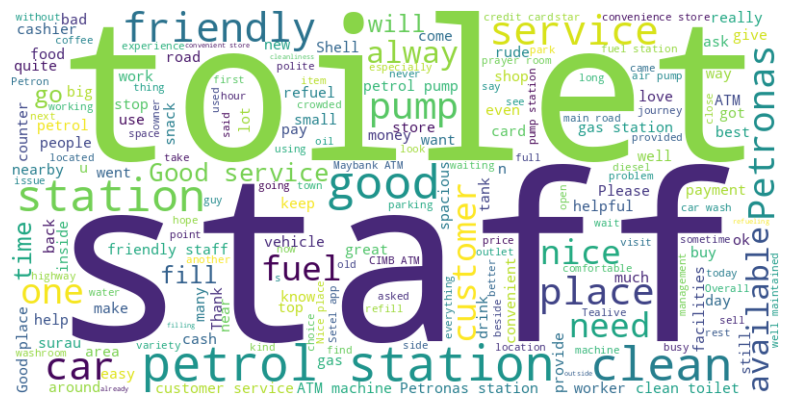

In [6]:
from wordcloud import WordCloud

# Combine all review text into one string for word cloud visualization
all_reviews_text = " ".join(df_all_reviews['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
df_all_reviews['rating'].mean()

3.895736512426753

In [9]:
df_all_reviews

,station_name,place_name,location,author_name,rating,text,time
0,TAMAN ANDA,Petronas Taman Anda,"4.629239,101.114431",Stephen ong,3,Another station charging higher than normal di...,1676626422
1,TAMAN ANDA,Petronas Taman Anda,"4.629239,101.114431",Che Syaiful,4,Got petrol here,1726010026
2,TAMAN ANDA,Petronas Taman Anda,"4.629239,101.114431",Mohammad Fithri Mohammad Sharifuddin,4,"most of the staff are very helpful, kind and a...",1601110289
3,TAMAN ANDA,Petronas Taman Anda,"4.629239,101.114431",Stephen lee,5,Staff always with smiling face,1600260670
4,TAMAN ANDA,Petronas Taman Anda,"4.629239,101.114431",Iqbal Hakim (Kim),5,"Its okay, typical petrol station.",1614015946
...,...,...,...,...,...,...,...
9893,BATU 5 GOMBAK,Petronas Batu 5 Jalan Gombak ( Mesra Ikhwan ),"3.212697,101.708571",raja aziera syahfiqah,1,Toilet is very bad like no maintenance taken a...,1709637382
9894,BATU 5 GOMBAK,Petronas Batu 5 Jalan Gombak ( Mesra Ikhwan ),"3.212697,101.708571",Mohd Syamsul Maksud,1,"Worst petro station, 50 years Pet yesterday, b...",1723973100
9895,BATU 5 GOMBAK,Petronas Batu 5 Jalan Gombak ( Mesra Ikhwan ),"3.212697,101.708571",Liza Idayu Zakaria,1,The toilet is soooo dirty. Flush is out of ord...,1697432855
9896,BATU 5 GOMBAK,Petronas Batu 5 Jalan Gombak ( Mesra Ikhwan ),"3.212697,101.708571",Izmine Azmine,4,Spaces n convinience atmosphere to drop by ...👌😊,1719944438


In [10]:
df_all_reviews.to_csv('petronas_station_reviews.csv')